In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('online_retail_II.xlsx')

In [3]:
#월별로 date 데이터 변환
df['InvoiceDate_month'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m'))

In [4]:
#일별로 date 데이터 변환
df['InvoiceDate_date'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m%d'))

In [5]:
#매출 컬럼 생성
df['sales'] = df['Quantity'] * df['Price']

## Monthly retention rate
* 지난달에 구매하고 재구매한 경우를 고객이 유지되었다고 보고 retention rate 계산

In [42]:
# MAU: 월별 1회 이상 구매한 고객의 수
mau = pd.DataFrame(df.groupby('InvoiceDate_month').nunique()['Customer ID'].reset_index()).rename(columns={'Customer ID':'mau'})

In [9]:
monthly_sales_per_user = df.groupby(['Customer ID', 'InvoiceDate_month'])['sales'].sum().reset_index()

In [15]:
mspu_pv = pd.pivot_table(monthly_sales_per_user, index=['Customer ID'], columns='InvoiceDate_month', aggfunc=np.sum).fillna(0).reset_index()

In [25]:
mspu_pv.columns = mspu_pv.columns.droplevel(0) #멀티 컬럼 제거

In [29]:
mspu_pv = mspu_pv.rename(columns={'':'customer_id'})

In [52]:
months = list(mspu_pv.columns[1:])

retained_users = list()
retained_users.append(0)

for i in range(1, len(months)):
    prev_month = months[i-1]
    month = months[i]
    ru = mspu_pv[(mspu_pv[prev_month]>0) & (mspu_pv[month]>0)][month].count()
    retained_users.append(ru)

In [54]:
mau['retained_users'] = retained_users

In [59]:
mau['retention_rate'] = mau['retained_users'] / mau['mau'] * 100

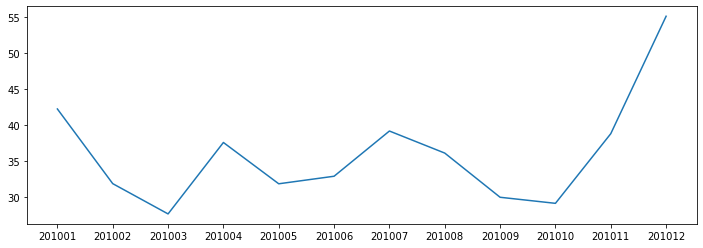

In [64]:
plt.figure(figsize=(12,4))
plt.plot(mau['InvoiceDate_month'][1:], mau['retention_rate'][1:])
plt.show()

# Cohort Analysis : Retention Rate